In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import VGG16
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

training_data = tf.convert_to_tensor(x_train, dtype=tf.float32)
testing_data = tf.convert_to_tensor(x_test, dtype=tf.float32)

training_data /= 255.0
testing_data /= 255.0

training_labels = y_train.flatten()
testing_labels = y_test.flatten()


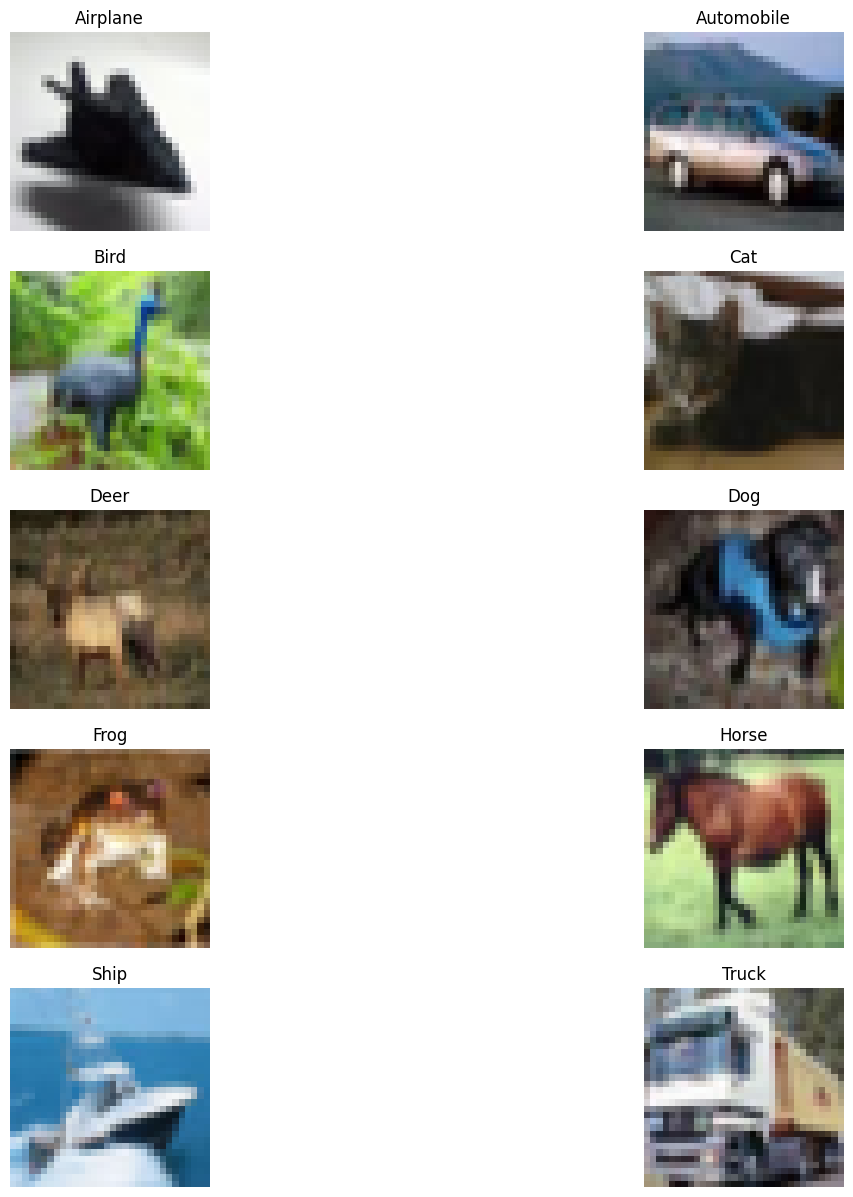

In [ ]:
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
               'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

plt.figure(figsize=(15, 15))
for i in range(10):
    index = np.where(training_labels == i)[0][0]
    plt.subplot(5, 2, i+1)
    plt.imshow(training_data[index])
    plt.title(class_names[i])
    plt.axis('off')
plt.show()


<ipython-input-23-ab99fd594d1f>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=training_labels, palette='viridis')


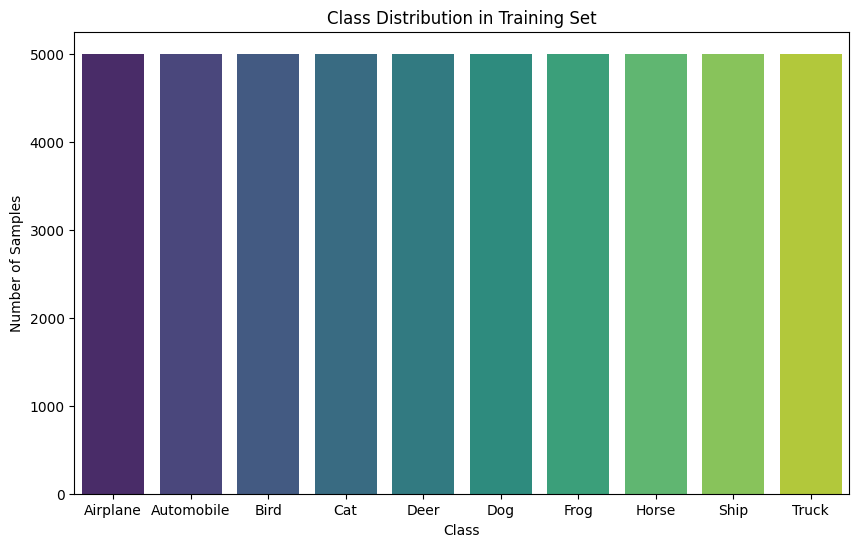

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(x=training_labels, palette='viridis')
plt.title('Class Distribution in Training Set')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.xticks(ticks=range(10), labels=class_names)
plt.show()


In [ ]:
augmentation = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

augmentation.fit(training_data)


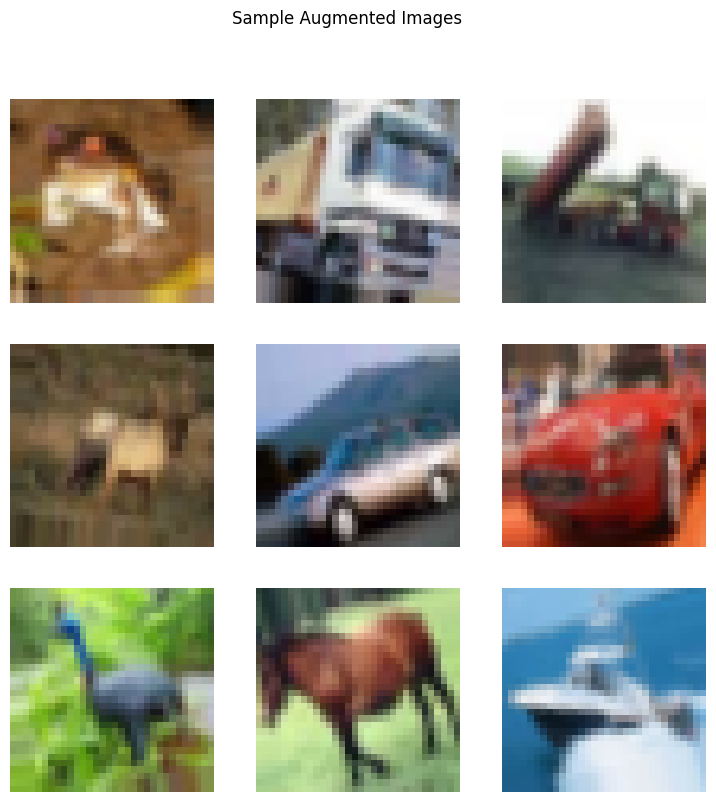

In [ ]:
augmented_iter = augmentation.flow(training_data, training_labels, batch_size=9, shuffle=False)
augmented_images, _ = next(augmented_iter)

plt.figure(figsize=(9,9))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(augmented_images[i])
    plt.axis('off')
plt.suptitle('Sample Augmented Images')
plt.show()


In [ ]:
def baseline_model():
    model = Sequential()
    model.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(32,32,3)))
    model.add(MaxPooling2D((2,2)))
    model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2,2)))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(10, activation='softmax'))

    optimizer = Adam()
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

baseline = baseline_model()
baseline.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)                   │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │         262,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 282,250 (1.08 MB)

 Trainable params: 282,250 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def deeper_model():
    model = Sequential()
    model.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(32,32,3)))
    model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2,2)))

    model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2,2)))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(10, activation='softmax'))

    optimizer = Adam()
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

deep = deeper_model()
deep.summary()


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)                   │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 512)                 │       2,097,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,168,362 (8.27 MB)

 Trainable params: 2,168,362 (8.27 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def dropout_model():
    model = Sequential()
    model.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(32,32,3)))
    model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.15))

    model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.20))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(10, activation='softmax'))

    optimizer = Adam()
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

dropout_net = dropout_model()
dropout_net.summary()


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)                   │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 512)                 │       2,097,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,168,362 (8.27 MB)

 Trainable params: 2,168,362 (8.27 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def batchnorm_model():
    model = Sequential()
    model.add(Conv2D(32, (3,3), padding='same', input_shape=(32,32,3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3,3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.15))

    model.add(Conv2D(64, (3,3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3,3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.20))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    model.add(Dense(10, activation='softmax'))

    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

batchnorm_net = batchnorm_model()
batchnorm_net.summary()


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_28 (Conv2D)                   │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_10 (Activation)           │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_11 (Activation)           │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_12 (Activation)           │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_13 (Activation)           │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 512)                 │       2,097,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │              

 Total params: 2,171,178 (8.28 MB)

 Trainable params: 2,169,770 (8.28 MB)

 Non-trainable params: 1,408 (5.50 KB)

In [ ]:
def lr_scheduler_model():
    model = Sequential()
    model.add(Conv2D(32, (3,3), padding='same', input_shape=(32,32,3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3,3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.15))

    model.add(Conv2D(64, (3,3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3,3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    model.add(Dense(10, activation='softmax'))

    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

lr_scheduler_net = lr_scheduler_model()
lr_scheduler_net.summary()


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_32 (Conv2D)                   │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_15 (Activation)           │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_33 (Conv2D)                   │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_16 (Activation)           │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_34 (Conv2D)                   │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_17 (Activation)           │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_35 (Conv2D)                   │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_18 (Activation)           │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 512)                 │       2,097,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │              

 Total params: 2,171,178 (8.28 MB)

 Trainable params: 2,169,770 (8.28 MB)

 Non-trainable params: 1,408 (5.50 KB)

In [ ]:
def transfer_learning_model():
    base = VGG16(weights='imagenet', include_top=False, input_shape=(32,32,3))
    base.trainable = False

    model = Sequential()
    model.add(base)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))

    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

transfer_net = transfer_learning_model()
transfer_net.summary()


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 1, 1, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,848,586 (56.64 MB)

 Trainable params: 133,898 (523.04 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

early_stop = EarlyStopping(monitor='val_loss', patience=10,  restore_best_weights=True, verbose=1)

checkpoint_baseline = ModelCheckpoint('best_baseline.keras', monitor='val_loss', save_best_only=True, verbose=1)

checkpoint_deeper = ModelCheckpoint('best_deeper.keras', monitor='val_loss', save_best_only=True, verbose=1)

checkpoint_dropout = ModelCheckpoint('best_dropout.keras', monitor='val_loss', save_best_only=True, verbose=1)

checkpoint_batchnorm = ModelCheckpoint('best_batchnorm.keras', monitor='val_loss', save_best_only=True, verbose=1)

checkpoint_lr = ModelCheckpoint('best_lr_scheduler.keras', monitor='val_loss', save_best_only=True, verbose=1)

checkpoint_transfer = ModelCheckpoint('best_transfer.keras', monitor='val_loss', save_best_only=True, verbose=1)


In [ ]:
histories = {}

def train_model(model, model_name, checkpoint):
    print("Training", model_name)
    history = model.fit(
        augmentation.flow(training_data, training_labels, batch_size=64),
        steps_per_epoch=len(training_data) // 64,
        epochs=5,
        validation_data=(testing_data, testing_labels),
        callbacks=[reduce_lr, early_stop, checkpoint],
        verbose=1
    )
    histories[model_name] = history
    loss, accuracy = model.evaluate(testing_data, testing_labels, verbose=0)
    print(model_name, "Test Accuracy:", accuracy)

train_model(baseline, 'Baseline Model', checkpoint_baseline)
train_model(deep, 'Deeper Model', checkpoint_deeper)
train_model(dropout_net, 'Dropout Model', checkpoint_dropout)
train_model(batchnorm_net, 'BatchNorm Model', checkpoint_batchnorm)
train_model(lr_scheduler_net, 'LR Scheduler Model', checkpoint_lr)
train_model(transfer_net, 'Transfer Learning Model', checkpoint_transfer)


Training Baseline Model
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


776/781 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.3532 - loss: 1.7780
Epoch 1: val_loss improved from inf to 1.33134, saving model to best_baseline.keras
781/781 ━━━━━━━━━━━━━━━━━━━━ 45s 51ms/step - accuracy: 0.3538 - loss: 1.7765 - val_accuracy: 0.5222 - val_loss: 1.3313 - learning_rate: 0.0010
Epoch 2/5
  1/781 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.4531 - loss: 1.5518

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss did not improve from 1.33134
781/781 ━━━━━━━━━━━━━━━━━━━━ 0s 623us/step - accuracy: 0.4531 - loss: 1.5518 - val_accuracy: 0.5122 - val_loss: 1.3549 - learning_rate: 0.0010
Epoch 3/5
775/781 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.5301 - loss: 1.3180
Epoch 3: val_loss improved from 1.33134 to 1.11129, saving model to best_baseline.keras
781/781 ━━━━━━━━━━━━━━━━━━━━ 37s 47ms/step - accuracy: 0.5302 - loss: 1.3176 - val_accuracy: 0.6073 - val_loss: 1.1113 - learning_rate: 0.0010
Epoch 4/5
  1/781 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5625 - loss: 1.3295
Epoch 4: val_loss improved from 1.11129 to 1.10044, saving model to best_baseline.keras
781/781 ━━━━━━━━━━━━━━━━━━━━ 1s 670us/step - accuracy: 0.5625 - loss: 1.3295 - val_accuracy: 0.6101 - val_loss: 1.1004 - learning_rate: 0.0010
Epoch 5/5
775/781 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.5888 - loss: 1.1649
Epoch 5: val_loss improved from 1.10044 to 1.00089, saving model to best_baseline.keras
78

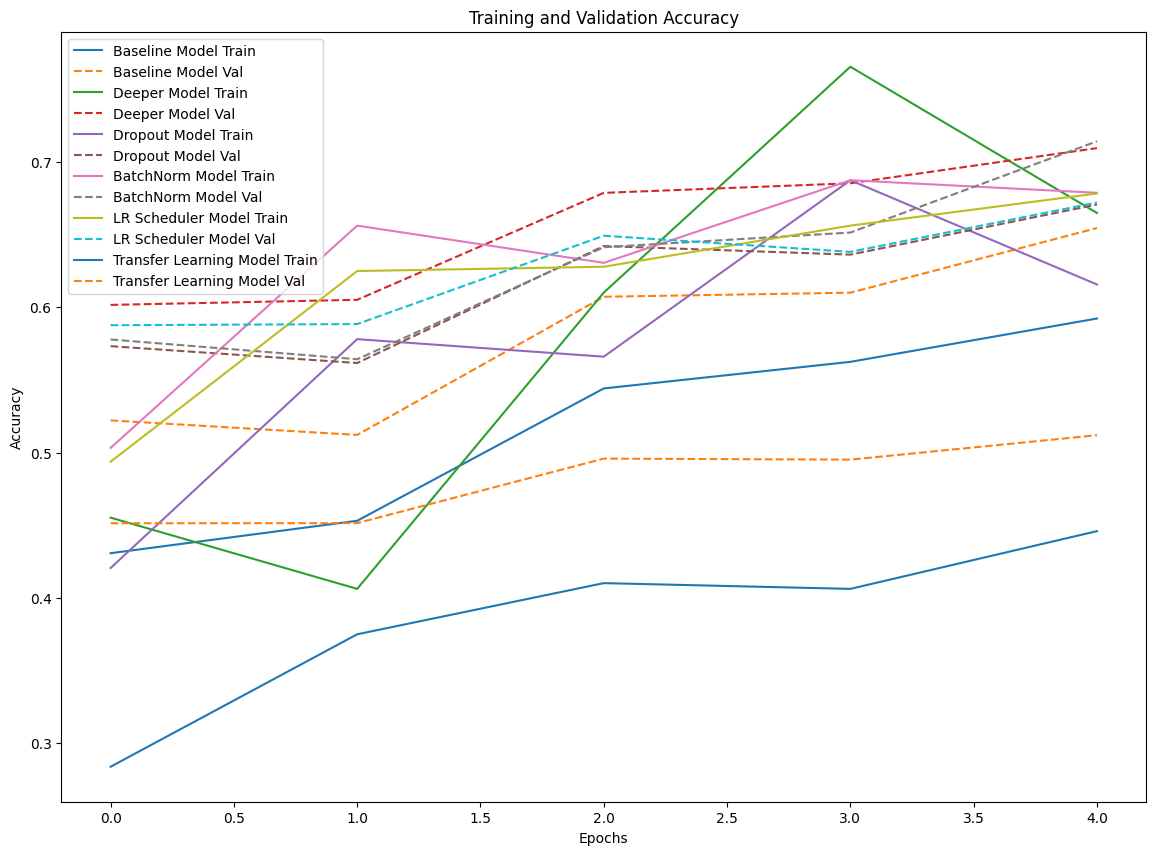

In [ ]:
plt.figure(figsize=(14,10))

for model_name, history in histories.items():
    plt.plot(history.history['accuracy'], label=model_name + ' Train')
    plt.plot(history.history['val_accuracy'], linestyle='--', label=model_name + ' Val')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


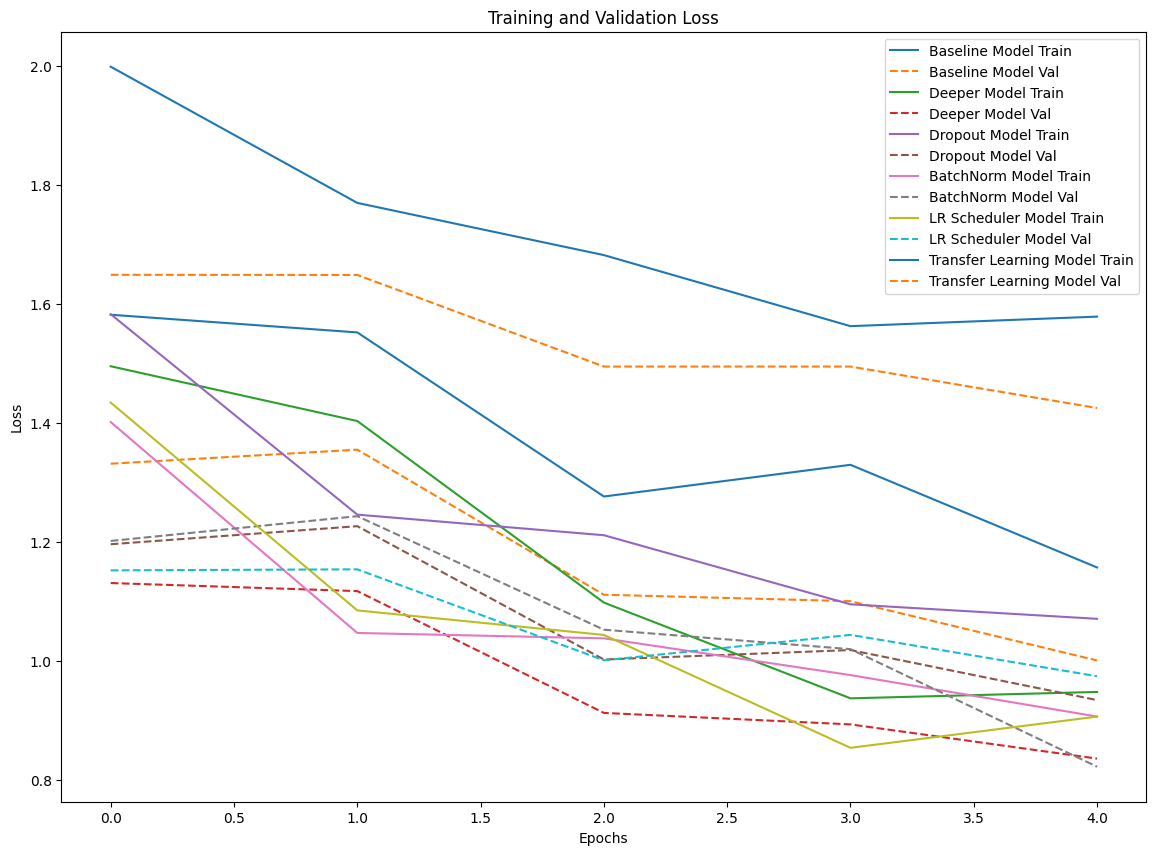

In [ ]:
plt.figure(figsize=(14,10))

for model_name, history in histories.items():
    plt.plot(history.history['loss'], label=model_name + ' Train')
    plt.plot(history.history['val_loss'], linestyle='--', label=model_name + ' Val')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step


AttributeError: 'str' object has no attribute 'items'

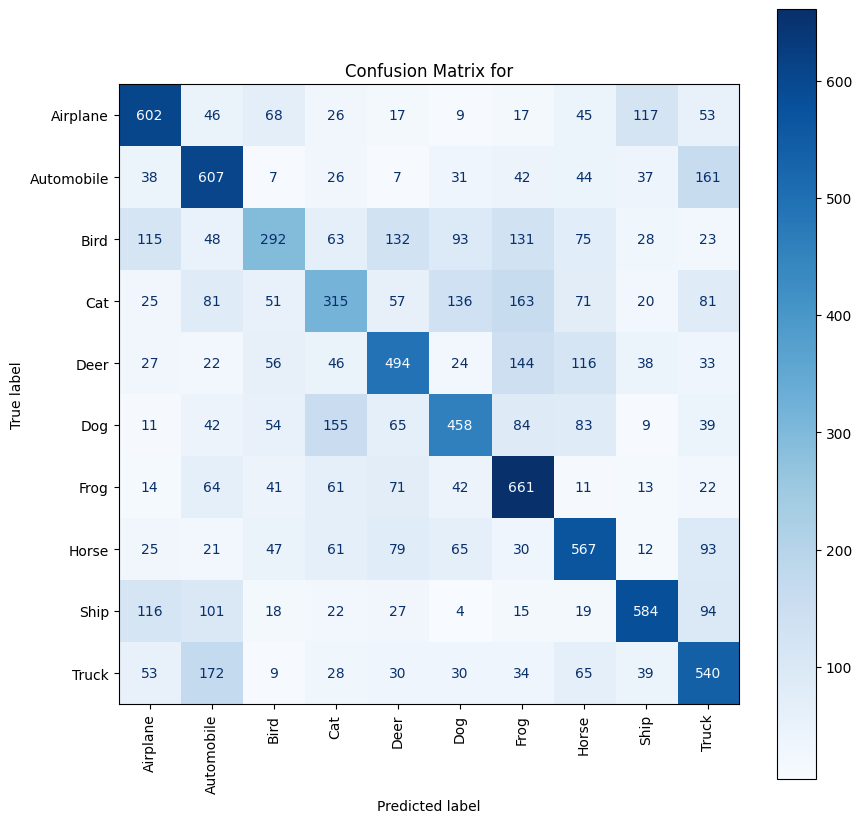

In [ ]:
def display_confusion_matrix(model, model_name):
    predictions = model.predict(testing_data)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = testing_labels

    cm = confusion_matrix(true_classes, predicted_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    fig, ax = plt.subplots(figsize=(10,10))
    disp.plot(ax=ax, cmap='Blues', xticks_rotation='vertical')
    plt.title("Confusion Matrix for", model_name)
    plt.show()

best_transfer_model = load_model('best_transfer.keras')
display_confusion_matrix(best_transfer_model, 'Transfer Learning Model')



Loading and evaluating Baseline Model...
Baseline Model - Test Loss: 1.0009, Test Accuracy: 0.6546
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Error loading Baseline Model from best_baseline.keras: 'str' object has no attribute 'items'

Loading and evaluating Deeper Model...
Deeper Model - Test Loss: 0.8361, Test Accuracy: 0.7096
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Error loading Deeper Model from best_deeper.keras: 'str' object has no attribute 'items'

Loading and evaluating Dropout Model...
Dropout Model - Test Loss: 0.9344, Test Accuracy: 0.6708
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Error loading Dropout Model from best_dropout.keras: 'str' object has no attribute 'items'

Loading and evaluating BatchNorm Model...
BatchNorm Model - Test Loss: 0.8224, Test Accuracy: 0.7143
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Error loading BatchNorm Model from best_batchnorm.keras: 'str' object has no attribute 'items'

Loading and evaluating LR Scheduler Model...
LR Scheduler Model - Test 

,Test Loss,Test Accuracy
Baseline Model,1.0009,0.6546
Deeper Model,0.8361,0.7096
Dropout Model,0.9344,0.6708
BatchNorm Model,0.8224,0.7143
LR Scheduler Model,0.9744,0.6722
Transfer Learning Model,1.4249,0.5120


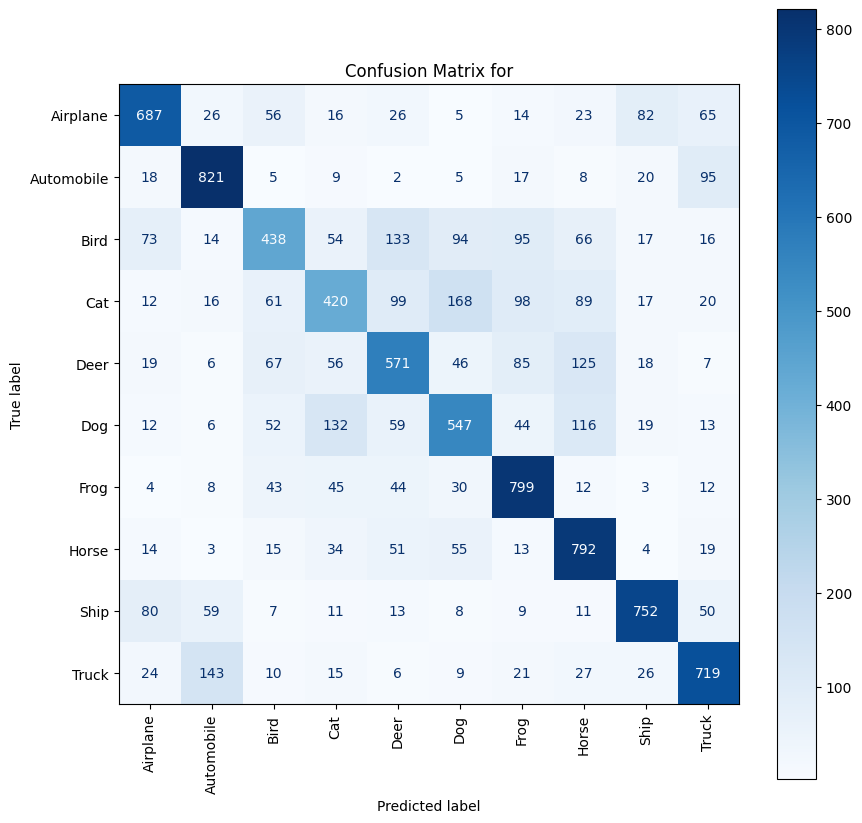

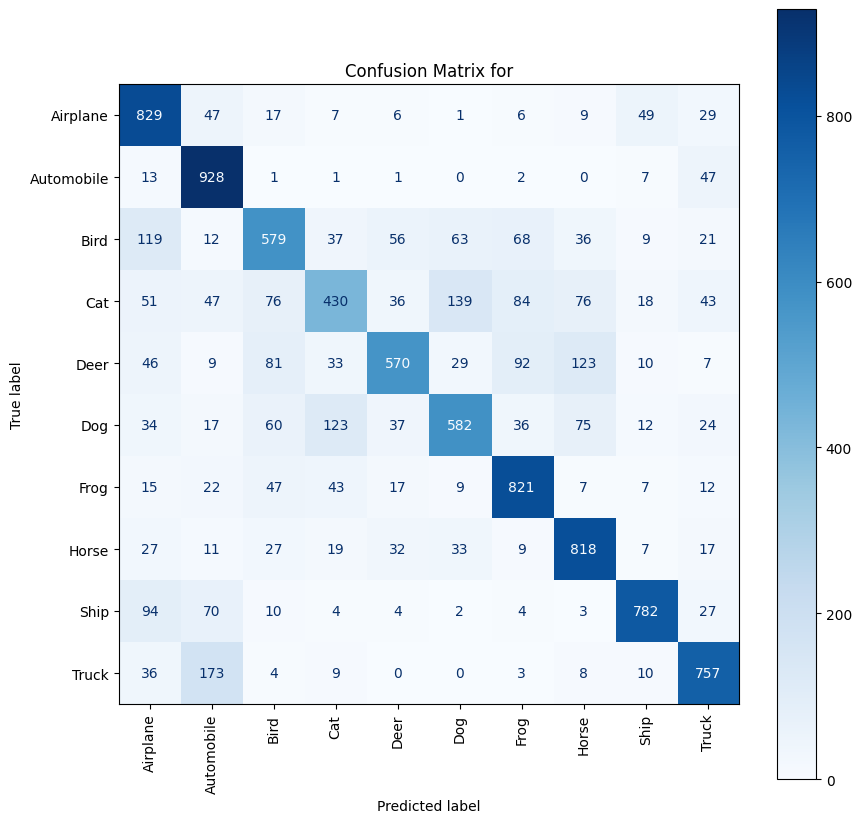

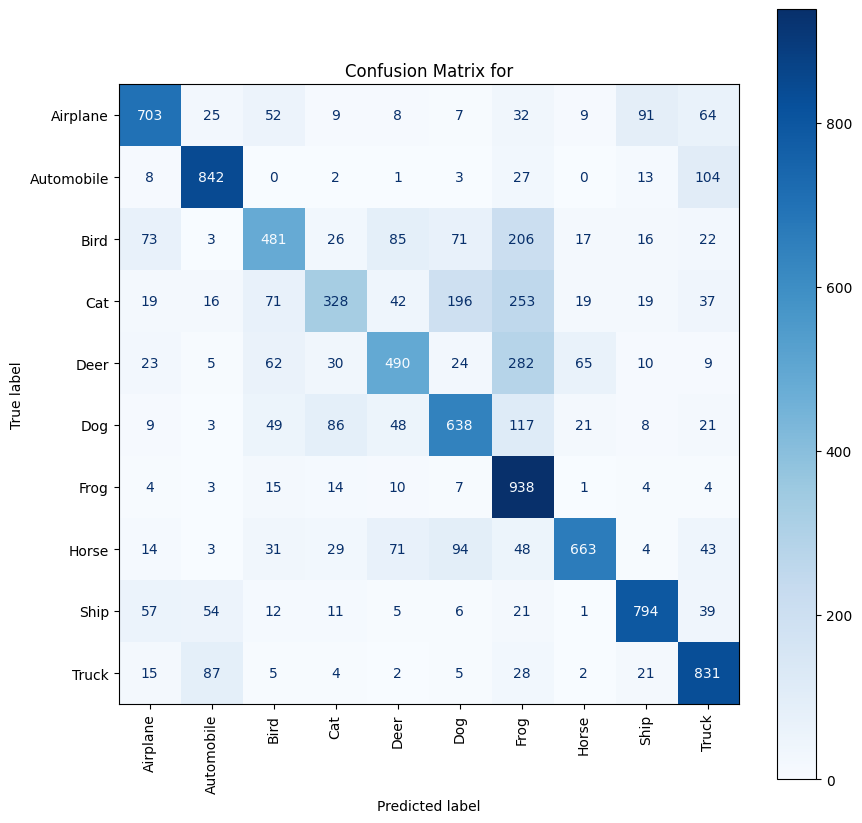

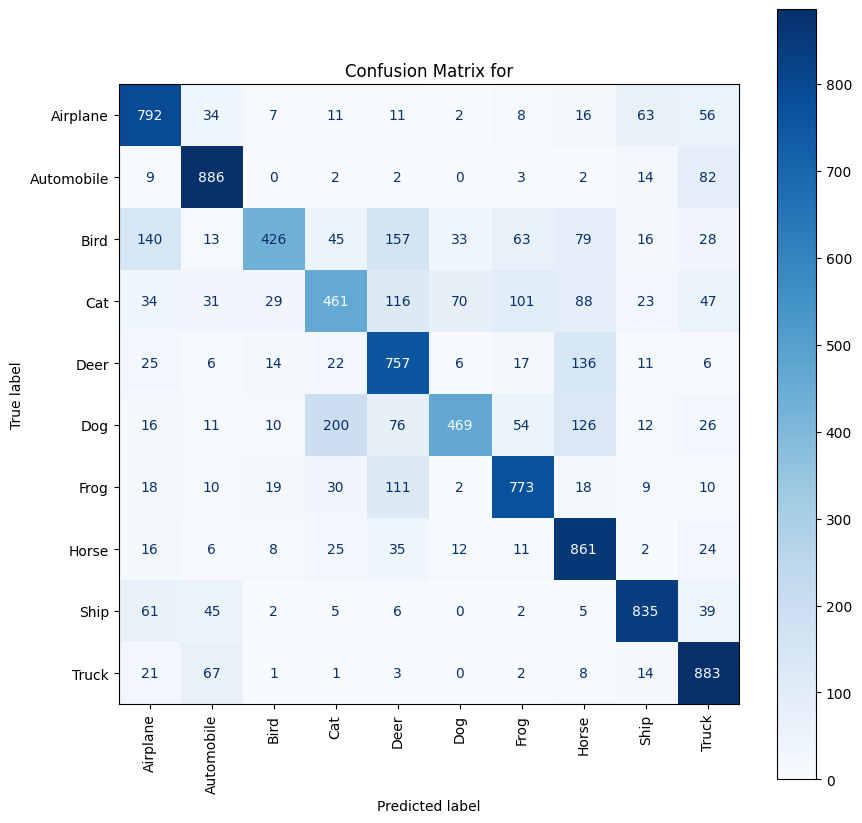

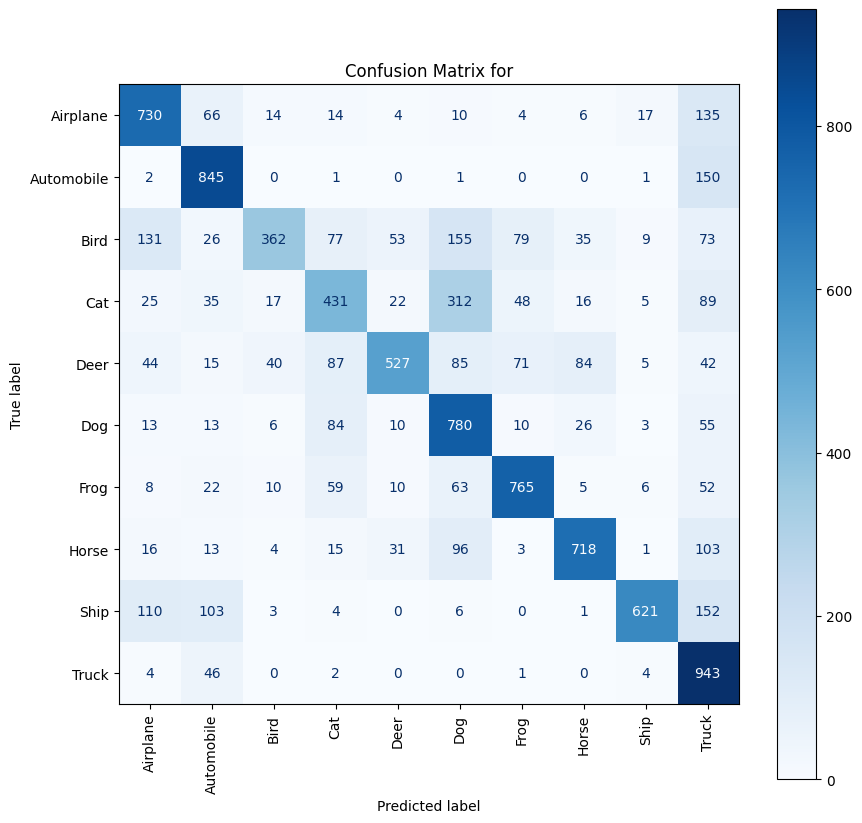

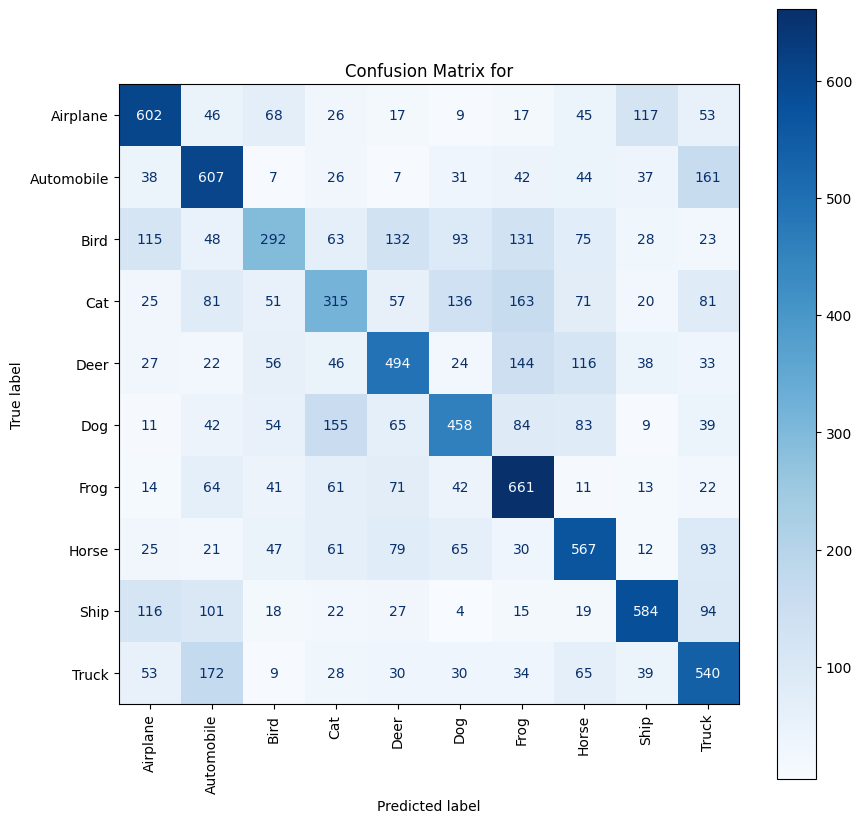

In [ ]:
model_files = {
    'Baseline Model': 'best_baseline.keras',
    'Deeper Model': 'best_deeper.keras',
    'Dropout Model': 'best_dropout.keras',
    'BatchNorm Model': 'best_batchnorm.keras',
    'LR Scheduler Model': 'best_lr_scheduler.keras',
    'Transfer Learning Model': 'best_transfer.keras'
}

test_results = {}

def evaluate_model(model, model_name):
    loss, accuracy = model.evaluate(testing_data, testing_labels, verbose=0)
    test_results[model_name] = {'loss': loss, 'accuracy': accuracy}
    print(model_name + " - Test Loss: " + str(loss) + ", Test Accuracy: " + str(accuracy))
    display_confusion_matrix(model, model_name)

for name, file in model_files.items():
    print("\nLoading and evaluating " + name + "...")
    try:
        model = load_model(file)
        evaluate_model(model, name)
    except Exception as e:
        print("Error loading " + name + " from " + file + ": " + str(e))

import pandas as pd

results_df = pd.DataFrame(test_results).T
results_df = results_df[['loss', 'accuracy']]
results_df = results_df.rename(columns={'loss': 'Test Loss', 'accuracy': 'Test Accuracy'})

print("\nSummary of All Models:")
display(results_df)
